In [1]:
import pandas as pd
import numpy as np
from random import shuffle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
from keras_adabound import AdaBound

Using TensorFlow backend.


In [3]:
df = pd.read_csv("../data/subplot.csv")
df1 = pd.read_csv("../data/subplot2.csv")

df = df.drop('IMAGERY_TITLE', axis = 1)
df1 = df1.drop('IMAGERY_TITLE', axis = 1)
df = pd.concat([df, df1], ignore_index = True)
df = df.dropna(axis = 0)


N_SAMPLES = int(df.shape[0]/196)
print(N_SAMPLES)

plot_ids = sorted(df['PLOT_ID'].unique())

336


In [4]:
df.head(5)

,PLOT_ID,SAMPLE_ID,LON,LAT,FLAGGED,ANALYSES,USER_ID,COLLECTION_TIME,ANALYSIS_DURATION,TREE
0,135191136,484051393,39.499458,14.078345,False,1,jo.m.brandt@gmail.com,2019-09-10 14:15:33.03602,131.1,0.0
1,135191136,484051394,39.499458,14.078432,False,1,jo.m.brandt@gmail.com,2019-09-10 14:15:33.03602,131.1,0.0
2,135191136,484051395,39.499458,14.078520,False,1,jo.m.brandt@gmail.com,2019-09-10 14:15:33.03602,131.1,0.0
3,135191136,484051396,39.499458,14.078607,False,1,jo.m.brandt@gmail.com,2019-09-10 14:15:33.03602,131.1,0.0
4,135191136,484051397,39.499458,14.078694,False,1,jo.m.brandt@gmail.com,2019-09-10 14:15:33.03602,131.1,0.0


In [5]:
def calc_bbox(plot_id):
    subs = df[df['PLOT_ID'] == plot_id]
    # TOP, LEFT, BOTTOM, RIGHT
    # (min x, min y), (max x, max y)
    return [(min(subs['LON']), min(subs['LAT'])), (max(subs['LON']), max(subs['LAT']))]

locations = [calc_bbox(x) for x in plot_ids]
locations[0]

[(39.499457864411035, 14.078345324474359),
 (39.50062567428038, 14.079478055220802)]

In [6]:
def reconstruct_images(plot_id):
    subs = df[df['PLOT_ID'] == plot_id]
    rows = []
    lats = reversed(sorted(subs['LAT'].unique()))
    for i, val in enumerate(lats):
        subs_lat = subs[subs['LAT'] == val]
        subs_lat = subs_lat.sort_values('LON', axis = 0)
        rows.append(list(subs_lat['TREE']))
    return rows

data = [reconstruct_images(x) for x in plot_ids]

In [7]:
def remove_blank_steps(array):
    to_update = {}
    sets = []
    for k in range(6):
        for i in range(array.shape[0]):
            for k in range(array.shape[-1]):
                mean = (np.mean(array[i, :, :, k]))
                if mean == 0:
                    sets.append(i)
                    if i < array.shape[0] - 1:
                        array[i, :, :, k] = array[i + 1, :, :, k]
                    else:
                        array[i, :, :, k] = array[i - 1, :, :, k]
                if mean == 1:
                    sets.append(i)
                    if i < array.shape[0] - 1:
                        array[i, :, :, k] = array[i + 1, :, :, k]
                    else:
                        array[i, :, :, k] = array[i - 1, :, :, k]
    for i in range(array.shape[0]):
        for k in range(array.shape[-1]):
            mean = (np.mean(array[i, :, :, k]))
            if mean == 0:
                if i < array.shape[0] - 2:
                    array[i, :, :, k] = array[i + 2, :, :, k]
                else:
                    array[i, :, :, k] = array[i - 2, :, :, k]
            if mean == 1:
                if i < array.shape[0] - 2:
                    array[i, :, :, k] = array[i + 2, :, :, k]
                else:
                    array[i, :, :, k] = array[i - 2, :, :, k]
    print(set(sets))
    return array

In [8]:
import os
image_size = 14

def ndvi(x):
    # (B8 - B4)/(B8 + B4)
    ndvis = [(im[:, :, 6] - im[:, :, 2]) / (im[:, :, 6] + im[:, :, 2]) for im in x]
    min_ndvi = min([np.mean(x) for x in ndvis])
    max_ndvi = max([np.mean(x) for x in ndvis])
    ndvis = [(x - min_ndvi / (max_ndvi - min_ndvi)) for x in ndvis]
    x_padding = np.zeros((x.shape[0], image_size, image_size, 1))
    x = np.concatenate((x, x_padding), axis = 3)
    # Iterate over each time step and add NDVI in as the 11th channel
    for i in range(x.shape[0]):
        x[i, :, :, 10] = ndvis[i]
    return x

# Initiate empty lists to store the X and Y data in
data_x = []
data_y = []
binary_y = []
data_location_x = []
data_location_y = []
lengths = []

# Iterate over each plot
pad = True
flip = True
for i in plot_ids:
    # Load the sentinel imagery
    x = np.load("../data/ids/" + str(i) + ".npy")
    # Shape check
    if x.shape[1] == image_size:
        x = ndvi(x)                # calc NDVI
        x = remove_blank_steps(x)
        y = reconstruct_images(i)
        if sum([sum(x) for x in y]) >= 1:
            binary_y.append(1)
        else:
            binary_y.append(0)
        lengths.append(x.shape[0])
        #x = np.median(x, axis = 0) # and calculate the median over the time steps
        if pad:
            if x.shape[0] < 24:
                print(x.shape[0])
                padding = np.zeros((24 - x.shape[0], image_size, image_size, 11))
                x = np.concatenate((x, padding), axis = 0)
        data_x.append(x)
        data_y.append(y)
        if flip:
                # FLIP HORIZONTAL
            x1 = np.flip(x, 1)
            data_x.append(x1)
            data_y.append(np.flip(y, 0))
            lengths.append(x.shape[0])
    
                # FLIP BOTH
            x2 = np.flip(x, 2)
            x2 = np.flip(x2, 1)
            data_x.append(x2)
            data_y.append(np.flip(y, [0, 1]))
            lengths.append(x.shape[0])
                # FLIP VERTICAL
            x3 = np.flip(x, 2)
            data_x.append(x3)
            data_y.append(np.flip(y, 1))
            lengths.append(x.shape[0])

data_x = np.stack(data_x)
data_y = np.stack(data_y)
data_y = np.reshape(data_y, (N_SAMPLES*4, 14, 14, 1))
binary_y = np.stack(binary_y)
lengths = np.stack(lengths)
lengths = np.reshape(lengths, (lengths.shape[0], 1))

set()
set()
22
set()
22
set()
22
set()
set()
22
set()
22
{6, 8, 9, 22, 23}
set()
22
set()
22
set()
set()
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
set()
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
{1, 2, 19}
set()
22
set()
22
{10, 12, 13}
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
{3, 4, 21}
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
set()
set()
22
set()
set()
22
set()
22
set()
22
set()
set()
22
set()
22
set()
22
set()
set()
22
set()
22
set()
22
set()
22
set()
22
set()
set()
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
set()
set()
22
set()
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22

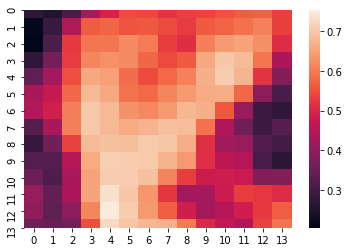

In [9]:
sns.heatmap(data_x[86, 16, :, :, 10]) # time 1, 

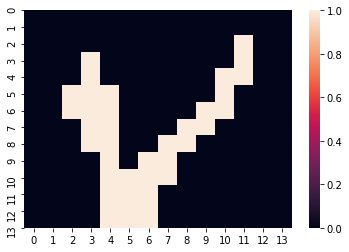

In [10]:
sns.heatmap(data_y[86].reshape(14, 14))

In [11]:
train_x = data_x[:int(len(data_x) * 0.8)]
train_y = data_y[:int(len(data_x) * 0.8)]
train_lengths = lengths[:int(len(data_x) * 0.8)]
train_binary = binary_y[:int(len(data_x) * 0.8)]

test_x = data_x[int(len(data_x) * 0.8):]
test_y = data_y[int(len(data_x) * 0.8):]
test_lengths = lengths[int(len(data_x) * 0.8):]
test_binary = binary_y[int(len(data_x) * 0.8):]

In [12]:
import tensorflow as tf
import numpy as np


def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


def lovasz_hinge(logits, labels):
        """
        Binary Lovasz hinge loss
          logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
          labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
          per_image: compute the loss per image instead of per batch
          ignore: void class id
        """
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log = tf.reshape(log, (-1,))
            lab = tf.reshape(lab, (-1,))
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        losses.set_shape((None,))
        loss = tf.reduce_mean(losses)
        return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss

In [13]:
from keras import backend as K
import tensorflow as tf

def binary_focal_loss(gamma=2., alpha=.25):
    
    def binary_focal_loss_fixed(y_true, y_pred):

        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed

In [14]:
def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    jac_loss = (1 - jac) * smooth
    return jac_loss

def bin_foc(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.sum(0.5 * K.pow(1. - pt_1, 2) * K.log(pt_1)) \
               -K.sum((1 - 0.5) * K.pow(pt_0, 2) * K.log(1. - pt_0))


def foc_jaccard(y_true, y_pred):
    jaccard_loss = jaccard_distance(y_true,y_pred)
    focal_loss = bin_foc(y_true, y_pred)
    summed = jaccard_loss + focal_loss
    return summed

def foc_lovasz(y_true, y_pred):
    #jaccard_loss = jaccard_distance(y_true, y_pred)
    lovasz = lovasz_hinge(y_pred, y_true)
    #pred_reshape = tf.reshape(y_pred, (-1, 14, 14))
    #true_reshape = tf.reshape(y_true, (-1, 14, 14))
    focal_loss = bin_foc(y_true, y_pred)
    summed = lovasz + focal_loss
    return summed
    

In [15]:
setattr(tf.nn.rnn_cell.RNNCell, '__deepcopy__', lambda self, _: self)

class ConvGRUCell(tf.nn.rnn_cell.RNNCell):
  """A GRU cell with convolutions instead of multiplications."""

  def __init__(self, shape, filters, kernel, padding = 'SAME', activation=tf.tanh, normalize=False, data_format='channels_last', reuse=None):
    super(ConvGRUCell, self).__init__(_reuse=reuse)
    self._filters = filters
    self._kernel = kernel
    self._activation = activation
    self._normalize = normalize
    self._padding = padding
    if data_format == 'channels_last':
        self._size = tf.TensorShape(shape + [self._filters])
        self._feature_axis = self._size.ndims
        self._data_format = None
    elif data_format == 'channels_first':
        self._size = tf.TensorShape([self._filters] + shape)
        self._feature_axis = 0
        self._data_format = 'NC'
    else:
        raise ValueError('Unknown data_format')

  @property
  def state_size(self):
    return self._size

  @property
  def output_size(self):
    return self._size

  def call(self, x, h):
    channels = x.shape[self._feature_axis].value

    with tf.variable_scope('gates'):
      inputs = tf.concat([x, h], axis=self._feature_axis)
      n = channels + self._filters
      m = 2 * self._filters if self._filters > 1 else 2
      W = tf.get_variable('kernel', self._kernel + [n, m])
      y = tf.nn.convolution(inputs, W, self._padding, data_format=self._data_format)
      if self._normalize:
        r, u = tf.split(y, 2, axis=self._feature_axis)
        r = tf.contrib.layers.layer_norm(r)
        u = tf.contrib.layers.layer_norm(u)
      else:
        y += tf.get_variable('bias', [m], initializer=tf.ones_initializer())
        r, u = tf.split(y, 2, axis=self._feature_axis)
      r, u = tf.sigmoid(r), tf.sigmoid(u)

    with tf.variable_scope('candidate'):
      inputs = tf.concat([x, r * h], axis=self._feature_axis)
      n = channels + self._filters
      m = self._filters
      W = tf.get_variable('kernel', self._kernel + [n, m])
      y = tf.nn.convolution(inputs, W, self._padding, data_format=self._data_format)
      if self._normalize:
        y = tf.contrib.layers.layer_norm(y)
      else:
        y += tf.get_variable('bias', [m], initializer=tf.zeros_initializer())
      h = u * h + (1 - u) * self._activation(y)

    return h, h

In [16]:
def castF(x):
    return K.cast(x, K.floatx())

def castB(x):
    return K.cast(x, bool)

def iou_loss_core(true,pred):  #this can be used as a loss if you make it negative
    intersection = true * pred
    notTrue = 1 - true
    union = true + (notTrue * pred)

    return (K.sum(intersection, axis=-1) + K.epsilon()) / (K.sum(union, axis=-1) + K.epsilon())

def competitionMetric2(true, pred): #any shape can go - can't be a loss function

    tresholds = [0.5 + (i*.05)  for i in range(10)]

    #flattened images (batch, pixels)
    true = K.batch_flatten(true)
    pred = K.batch_flatten(pred)
    pred = castF(K.greater(pred, 0.5))

    #total white pixels - (batch,)
    trueSum = K.sum(true, axis=-1)
    predSum = K.sum(pred, axis=-1)

    #has mask or not per image - (batch,)
    true1 = castF(K.greater(trueSum, 1))    
    pred1 = castF(K.greater(predSum, 1))

    #to get images that have mask in both true and pred
    truePositiveMask = castB(true1 * pred1)

    #separating only the possible true positives to check iou
    testTrue = tf.boolean_mask(true, truePositiveMask)
    testPred = tf.boolean_mask(pred, truePositiveMask)

    #getting iou and threshold comparisons
    iou = iou_loss_core(testTrue,testPred) 
    truePositives = [castF(K.greater(iou, tres)) for tres in tresholds]

    #mean of thressholds for true positives and total sum
    truePositives = K.mean(K.stack(truePositives, axis=-1), axis=-1)
    truePositives = K.sum(truePositives)

    #to get images that don't have mask in both true and pred
    trueNegatives = (1-true1) * (1 - pred1) # = 1 -true1 - pred1 + true1*pred1
    trueNegatives = K.sum(trueNegatives) 

    return (truePositives + trueNegatives) / castF(K.shape(true)[0])

In [43]:
import keras
from keras.models import Sequential, Model
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers import *
from keras.layers import Flatten, Dense, Input
from keras.layers import Lambda
from keras.layers import ELU
from functools import partial

tf.reset_default_graph()

def convGRU(x, cell, ln):
    output, final = tf.nn.bidirectional_dynamic_rnn(
        cell, cell, x, ln, dtype=tf.float32)
    output = tf.concat(output, -1)
    final = tf.concat(final, -1)
    return [output, final]

def blank_fn(x):
    return x

class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

def conv_lstm_model():
    inp = Input(shape = (24, 14, 14, 11))
    lengths = Input(shape = (1,), dtype=tf.int32)
    length2 = tf.reshape(lengths, (-1,))
    
    
   
    # Downsampling Block 1 (14 x 14)
    with tf.variable_scope('14_7'):
        cell_10 = ConvGRUCell(shape = [14, 14],
                       filters = 32,
                       kernel = [3,3],
                       padding = 'SAME')
        
        output, final = tf.nn.bidirectional_dynamic_rnn(
            cell_10, cell_10, inp, length2, dtype=tf.float32)
        output = tf.concat(output, -1)
        final = tf.concat(final, -1)
        
        output = Lambda(lambda t: blank_fn(t))(output)
        print(output)
        final = Lambda(blank_fn)(final)
        #x = Lambda(lambda t: convGRU(t, cell_10, length2))(inp)
        
        # Return the final state and the output states
        #x = Lambda(lambda t: convGRU(t))(inp)
        # I think there needs to be a TimeDistributed(Conv2D) here first
        # With a TimeDistributed(ELU())
        downsampled = TimeDistributed(MaxPool2D(pool_size = (2, 2)))(output)
        
    # Downsampling block 2 (7 x 7)
    with tf.variable_scope('7'):
        cell_7 = ConvGRUCell(shape = [7, 7],
                       filters = 64,
                       kernel = [3,3],
                       padding = 'SAME')
        
        state_7 = Lambda(lambda t: convGRU(t, cell_7, length2))(downsampled)

    conv_block_7_u = Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same')(state_7[1])
    elu_7_u = ELU()(conv_block_7_u)

    # Upsampling final block (14 x 14)
    upsampling_14 = UpSampling2D()(elu_7_u)
    #padded = ZeroPadding2D((1, 1))(upsampling_14)
    padded = ReflectionPadding2D((1, 1))(upsampling_14)
    fm = Conv2D(filters = 64,
                kernel_size = (3, 3), 
                padding = 'valid',
                )(padded)
    elu = ELU()(fm)
    concat = Concatenate(axis = -1)([elu, final])
    #$padded = ZeroPadding2D((1, 1))(concat)
    padded = ReflectionPadding2D((1, 1))(concat)
    fm = Conv2D(filters = 32,
                kernel_size = (3, 3), 
                padding = 'valid',
                )(padded)
    elu = ELU()(fm)
    
    # Output layer
    fm = Conv2D(filters = 1,
                kernel_size = (1, 1), 
                padding = 'valid',
                activation = 'sigmoid'
                )(elu)
    mod = Model(inputs = [inp, lengths],  outputs = fm)
    mod.summary()
    return mod

m = conv_lstm_model()

Tensor("14_7/lambda_1/Identity:0", shape=(?, 24, 14, 14, 64), dtype=float32)


AttributeError: 'NoneType' object has no attribute '_inbound_nodes'

In [49]:
tf.keras.models.save_model(m, 'tf_model.h5')

TypeError: can't pickle _thread.RLock objects

In [45]:
?keras.model.save

Object `keras.model.save` not found.


In [28]:
from keras.callbacks import ModelCheckpoint

mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [35]:
#m = keras.models.load_model('best_model.h5', custom_objects = {'convGRU': ConvGRU})
#m.load_weights("232.hdf5")
#m.load_weights(".mdl_wts.hdf5")
m.compile(loss = [foc_lovasz],
          optimizer=AdaBound(lr=0.0001, final_lr=0.001),  metrics=[competitionMetric2])

In [37]:
m.fit([train_x, train_lengths],
      train_y, 
      validation_data = (([test_x, test_lengths], test_y)),
      batch_size=32,
      epochs = 500,
      #callbacks=[mcp_save],
      #class_weight=[0.1, 0.9],
)

Train on 1075 samples, validate on 269 samples
Epoch 1/500


NotFoundError: PruneForTargets: Some target nodes not found: training/group_deps 

In [30]:
#m.load_weights(".mdl_wts.hdf5")


TypeError: can't pickle _thread.RLock objects

In [ ]:
# 4 looks good, 0, 76, 90, 96, 108, 22, 56, 63, 55, 80

## 21, 98, 105, 15, 210, 235

true = test_y[21].reshape(14, 14)

plt.figure(figsize=(8.5, 7))
sns.heatmap(true)

In [ ]:
pred = m.predict([test_x[21].reshape(1, 24, 14, 14, 11), test_lengths[0]])
pred = pred.reshape(14, 14)
pred[np.where(pred > 0.35)] = 1
#pred[np.where(pred < 0.5)] = 0
#pred[np.where(pred < 0.5)] = 0

plt.figure(figsize=(8.5, 7))

# 111
sns.heatmap(pred, vmin=0, vmax=1)

In [ ]:
def half_hectare_accuracy(true, pred):
    eps = 1e-9
    true_x = np.split(true, indices_or_sections = 2, axis = 0)
    true_y = [np.split(x, 2, 1) for x in true_x]
    true_xy = [item for sublist in true_y for item in sublist]
    true = [np.sum(x) for x in true_xy]
    
    pred_x = np.split(pred, indices_or_sections = 2, axis = 0)
    pred_y = [np.split(x, 2, 1) for x in pred_x]
    pred_xy = [item for sublist in pred_y for item in sublist]
    pred = [np.sum(x) for x in pred_xy]
    
    recall = [min(x / y, 1) for x, y in zip(pred, true) if y > 0]
    precision = [(x - y) / x for x, y in zip(pred, true)]
    for i, val in enumerate(precision):
        if val < 0:
            precision[i] = 1
    return np.mean(recall), np.mean(precision)

half_hectare_accuracy(true, pred)

In [ ]:
def thirty_meter(true, pred):
    indices_x = np.random.randint(0, 11, 3)
    indices_y = np.random.randint(0, 11, 3)
    indexes = ([([a, a + 2], [b, b + 2]) for a,b in zip(indices_x, indices_y)])
    subs_true = []
    subs_pred = []
    for i in indexes:
        true_i = true[i[0][0]:i[0][1], i[1][0]:i[1][1]]
        pred_i = pred[i[0][0]:i[0][1], i[1][0]:i[1][1]]
        subs_true.append(true_i)
        subs_pred.append(pred_i)
    pred = [np.sum(x) for x in subs_pred]
    true = [np.sum(x) for x in subs_true]
    true_positives = []
    false_positives = []
    false_negatives = []
    for p, t in zip(pred, true):
        if p > t:
            tp = p - (p - t)
            fp = p - tp
            fn = 0
        if t >= p:
            tp = t
            fp = 0
            fn = t - p
        true_positives.append(tp)
        false_positives.append(fp)
        false_negatives.append(fn)
    prec = [x / (x + y) for x,y in zip(true_positives, false_positives) if (x+y) > 0]
    rec = [x / (x + y) for x,y in zip(true_positives, false_negatives) if (x+y) > 0]
    
    #recall = [min(x / y, 1) for x, y in zip(pred, true) if y > 0]
    #precision = [(y - x) / x for x, y in zip(pred, true)]
    #print(precision)
    return np.mean(rec), np.mean(prec) 

In [234]:
recalls = []
precisions = []
for i in range(len(test_y)):
    true = test_y[i].reshape((14, 14))
    pred = m.predict([test_x[i].reshape(1, 24, 14, 14, 11), test_lengths[i]])
    pred = pred.reshape(14, 14)
    pred[np.where(pred > 0.45)] = 1
    pred[np.where(pred < 0.45)] = 0
    rec, prec = thirty_meter(true, pred)
    #rec, prec = half_hectare_accuracy(true, pred)
    recalls.append(rec)
    precisions.append(prec)
    print(prec, rec)

0.5 1.0
nan nan
nan nan
nan nan
0.0 nan
0.8333333333333333 0.75
0.875 1.0
1.0 0.5
1.0 0.625
nan nan
1.0 0.5
nan nan
nan nan
0.6666666666666666 0.5
nan nan
1.0 0.5
nan nan
0.75 0.8333333333333333
0.4166666666666667 1.0
0.3333333333333333 1.0
1.0 1.0
1.0 0.5
1.0 0.5833333333333333
1.0 0.5
1.0 0.5
0.6666666666666666 0.875
0.8333333333333334 0.6666666666666666
1.0 1.0
0.8888888888888888 0.8333333333333334
0.8333333333333334 1.0
0.5 1.0
1.0 0.5
1.0 0.611111111111111
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
1.0 1.0
0.8888888888888888 1.0
0.8333333333333334 0.9333333333333332
0.6666666666666666 1.0
nan nan
1.0 0.5
nan nan
nan nan
1.0 0.6
1.0 0.5
1.0 0.5238095238095238
1.0 0.5833333333333334
1.0 0.5
1.0 1.0
1.0 0.65
1.0 0.5
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
1.0 0.5
nan nan
nan nan
0.0 nan
0.0 nan
nan nan
0.0 nan
1.0 1.0
0.125 1.0
0.0 nan
0

In [235]:
np.mean([x for x in recalls if not np.isnan(x)])

0.6924485305673425

In [236]:
np.mean([x for x in precisions if not np.isnan(x)])

0.7488425925925927

## PREDICT ON TEST WALL-TO-WALL

In [237]:
pred_x = []
pred_len = []
pred_files = ["../data/test/" + str(x) + ".npy" for x in range(0, 14)]
SHAPE_X = 7
SHAPE_Y = 2

In [238]:
pred_files

['../data/test/0.npy',
 '../data/test/1.npy',
 '../data/test/2.npy',
 '../data/test/3.npy',
 '../data/test/4.npy',
 '../data/test/5.npy',
 '../data/test/6.npy',
 '../data/test/7.npy',
 '../data/test/8.npy',
 '../data/test/9.npy',
 '../data/test/10.npy',
 '../data/test/11.npy',
 '../data/test/12.npy',
 '../data/test/13.npy']

In [239]:
for i in pred_files:
    data = np.load(i)
    data = ndvi(data)
    data = remove_blank_steps(data)
    pred_len.append(data.shape[0])
    if data.shape[0] < 24:
        padding = np.zeros((24 - data.shape[0], 14, 14, 11))
        data = np.concatenate((data, padding), axis = 0)
    pred_x.append(data)
pred_len = np.stack(pred_len).reshape((len(pred_len), 1))
    

set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()


In [240]:
preds = []
for i in range(0, SHAPE_X * SHAPE_Y):
    pr = m.predict([pred_x[i].reshape(1, 24, 14, 14, 11), pred_len[i]])
    pr = pr.reshape(14, 14)
    preds.append(pr)

row1 = np.concatenate(preds[:SHAPE_X], axis = 1)
row2 = np.concatenate(preds[SHAPE_X:], axis = 1)
row2.shape

(14, 98)

In [241]:
stacked = np.concatenate((row2, row1), axis = 0)
stacked.shape
#tacked = stacked.reshape((14, 70))
stacked[np.where(stacked > 0.47)] = 1
stacked[np.where(stacked < 0.47)] = 0

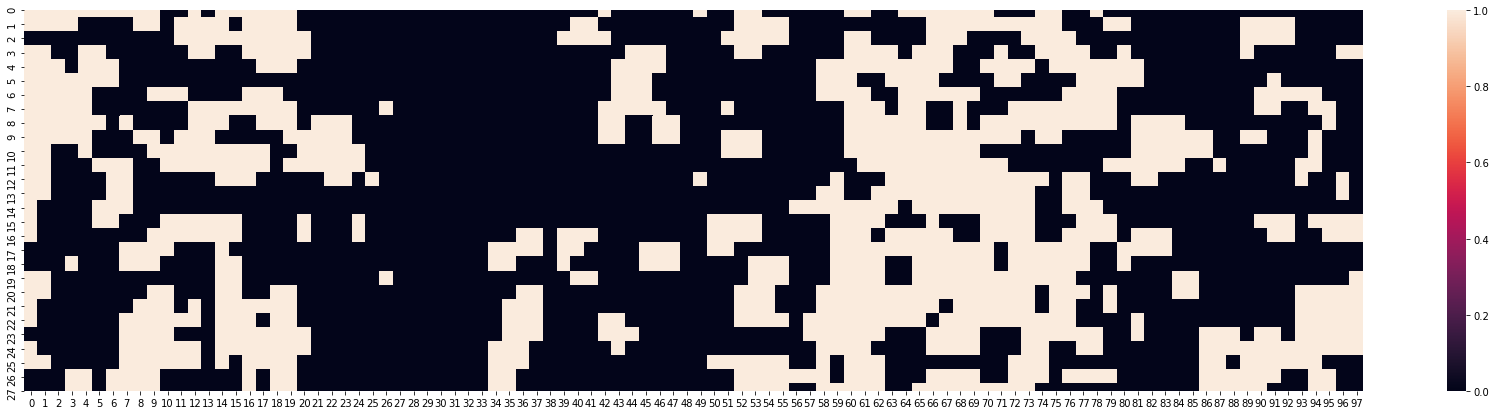

In [242]:
plt.figure(figsize=(30, 7))
sns.heatmap(stacked)

In [66]:
stacked.shape

(28, 98)

In [73]:
aggregated = []
for i, k in zip(range(0, stacked.shape[0], 2), (range(0, stacked.shape[1], 2))):
    print(i, k)

0 0
2 2
4 4
6 6
8 8
10 10
12 12
14 14
16 16
18 18
20 20
22 22
24 24
26 26


In [74]:
range(0, stacked.shape[1], 2)

range(0, 98, 2)